In [3]:
import yaml
import awkward as aw
import uproot
import hist
import math

from util import * 
import random
import time

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cloudpickle
import pickle

# Scikit-learn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay,  classification_report
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, learning_curve, ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer

#XGBoost
import xgboost as xgb

# Scipy
from scipy.stats import ks_2samp
from scipy.stats import kstest


# Desactiva las advertencias (warnings)
import warnings
warnings.filterwarnings("ignore")

In [4]:
datasets = ['frvz_ggf_508885', 'frvz_ggf_508886', 'frvz_ggf_508887', 'frvz_ggf_508888', 'frvz_ggf_508889', 'frvz_ggf_508890', 'frvz_ggf_508891',
            'frvz_ggf_508892', 'frvz_ggf_508893', 'frvz_vbf_500757_02-00', 'frvz_vbf_500758_02-00',
            'frvz_vbf_500759_02-00', 'frvz_vbf_500760_02-00', 'frvz_vbf_500761_02-00', 'frvz_vbf_500762_02-00', 'frvz_vbf_500763_02-00', 'frvz_vbf_500764_02-00']

BDT_inputs = [
    #------------------ Escenciales los cortes originales ------------------------#
    'mjj', 'njet30', 'detajj', 'dphijj',# 'neleSignal', 'nmuSignal', 'hasBjet','metTrig',
    'MET', #'LJ1_type', 'LJmu1_isGood', 'LJmu1_centrality',
    #------------------- Variables para cálculo de weights ------------------------#
    "scale1fb", #cross section
    "intLumi", #luminosidad

   #------------------ Otras variables a gráfiar ------------------------# 
   
    "jet1_pt", "jet1_eta", "jet1_phi", "jet1_e", 
    "jet2_pt", "jet2_eta", "jet2_phi", "jet2_e", 
    "signetajj",  #"dphi_j1met", "min_dphi_jetmet", 
    #"nLJ20","nLJjets20", "LJjet1_pt", "LJjet1_eta", "LJjet1_phi", "LJjet1_m", 
    #"LJjet1_width", "LJjet1_EMfrac", "LJjet1_timing", "LJjet1_jvt", "LJjet1_gapRatio", "LJjet1_BIBtagger", 
    #"LJjet1_DPJtagger", "LJjet1_truthDPidx", "nLJmus20",  
    "METsig", "METOSqrtHT", #"nLJmus20", 
    #"neleBaseline", "nmuBaseline", 
    #"hasBjet", "metTrig",
    #"LJjet1_isoID", "LJ1_type","LJjet1_timing",
    #"LJmu1_eta", "LJmu1_mu1DNNscore", "LJmu1_charge", "LJmu1_isoID",
            ]
df = read_data(datasets = datasets, variables=BDT_inputs, carpeta='C:/Users/jav90/Desktop/dpj/production_analysis/analisis_javier/Samples/')


frvz_ggf_508885
frvz_ggf_508886
frvz_ggf_508887
frvz_ggf_508888
frvz_ggf_508889
frvz_ggf_508890
frvz_ggf_508891
frvz_ggf_508892
frvz_ggf_508893
frvz_vbf_500757_02-00
frvz_vbf_500758_02-00
frvz_vbf_500759_02-00
frvz_vbf_500760_02-00
frvz_vbf_500761_02-00
frvz_vbf_500762_02-00
frvz_vbf_500763_02-00
frvz_vbf_500764_02-00


In [5]:
df.shape

(4628576, 20)

# Preprocesamiento de los datos

In [6]:
df1 = df.copy()
df1 = df1[df1['weights'] >= 0] #eliminar weights negativos y ceros
df1['VBF label'] = df1['tipo'].apply(lambda x: 1 if x == 'vbf' else 0) #crear columna con 1 para vbf y 0 para ggf

ml_var = [
    #------------------ Escenciales los cortes originales ------------------------#
   # 'mjj',
    #'njet30', 
    'detajj', 
    #'dphijj',# 'neleSignal', 'nmuSignal', 'hasBjet','metTrig',
    #'MET', #'LJ1_type', 'LJmu1_isGood', 'LJmu1_centrality',
    #------------------- Variables para cálculo de weights ------------------------#
    #"scale1fb", #cross section
    #"intLumi", #luminosidad

   #------------------ Otras variables a gráfiar ------------------------# 
   
  "jet1_pt", #"jet1_eta", #"jet1_phi", #"jet1_e", 
    #"jet2_pt",
    #"jet2_eta", 
   # "jet2_phi", #"jet2_e", 
   # "signetajj",  #"dphi_j1met", "min_dphi_jetmet", 
    #"nLJ20","nLJjets20", "LJjet1_pt", "LJjet1_eta", "LJjet1_phi", "LJjet1_m", 
    #"LJjet1_width", "LJjet1_EMfrac", "LJjet1_timing", "LJjet1_jvt", "LJjet1_gapRatio", "LJjet1_BIBtagger", 
    #"LJjet1_DPJtagger", "LJjet1_truthDPidx", "nLJmus20",  
    #"METsig", 
   # "METOSqrtHT", #"nLJmus20", 
    #"neleBaseline", "nmuBaseline", 
    #"hasBjet", "metTrig",
    #"LJjet1_isoID", "LJ1_type","LJjet1_timing",
    #"LJmu1_eta", "LJmu1_mu1DNNscore", "LJmu1_charge", "LJmu1_isoID",
            ]

# Separo ggF y VBF para realizar los cortes
X_ggf = df1[df1['tipo'] == 'ggf']
X_ggf = X_ggf[X_ggf['mjj']< 900000] #cortes de ggF mjj < 900000
X_ggf_sampled = X_ggf.sample(n=370000, random_state=228) #Datos de ggF que se usarán para entrenar el modelo
not_sampled_ggf = X_ggf.drop(X_ggf_sampled.index)

X_vbf = df1[df1['tipo'] == 'vbf']
print(X_vbf.shape)
X_vbf = X_vbf[X_vbf['njet30'] > 1] #cortes de VBF njets30 > 1
print(X_vbf.shape)
X_vbf = X_vbf[X_vbf['mjj'] >= 900000] #cortes de VBF mjj > 900000
print(X_vbf.shape)
X_ggf_vbf = pd.concat([X_ggf_sampled, X_vbf], axis=0) #Datos de ggF y VBF que se usarán para entrenar el modelo
# X_ggf_vbf = X_ggf_vbf[X_ggf_vbf["mjj"] > 90000]
X_ggf_vbf_completo = pd.concat([X_ggf, X_vbf], axis=0) #Datos de ggF y VBF que se usarán para evaluar el modelo con todos los datos

(491044, 21)
(491044, 21)
(360545, 21)


In [7]:
print(X_ggf_sampled.shape)
print(X_vbf.shape)


(370000, 21)
(360545, 21)


Distribución de eventos inciales (con corte de weights >= 0)

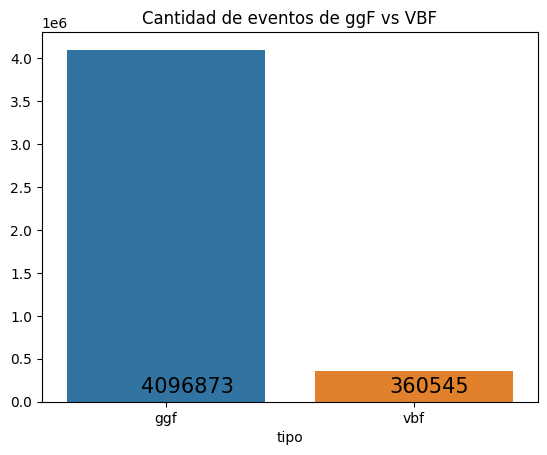

In [8]:
sns.barplot(x=X_ggf_vbf_completo['tipo'].value_counts().index, y=X_ggf_vbf_completo['tipo'].value_counts().values)
plt.title('Cantidad de eventos de ggF vs VBF')
plt.text(-0.1, 100000, X_ggf_vbf_completo['tipo'].value_counts().values[0], fontsize=15)
plt.text(0.9, 100000, X_ggf_vbf_completo['tipo'].value_counts().values[1], fontsize=15)
plt.show()  

Distribución de eventos para el entrenamiento y test del modelo

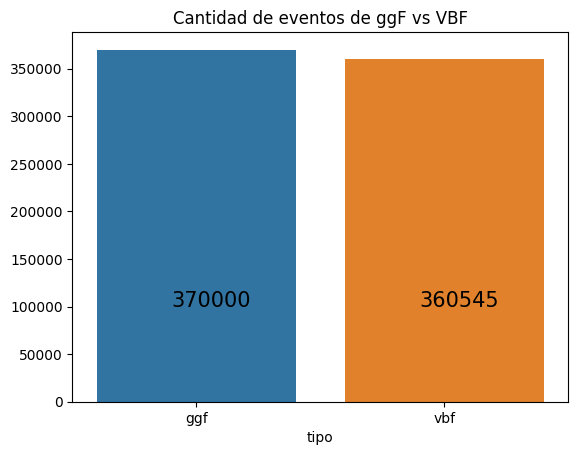

In [9]:
#X_ggf_vbf = X_ggf_vbf[X_ggf_vbf["mjj"] > 900000]
sns.barplot(x=X_ggf_vbf['tipo'].value_counts().index, y=X_ggf_vbf['tipo'].value_counts().values)
plt.title('Cantidad de eventos de ggF vs VBF')
plt.text(-0.1, 100000, X_ggf_vbf['tipo'].value_counts().values[0], fontsize=15)
plt.text(0.9, 100000, X_ggf_vbf['tipo'].value_counts().values[1], fontsize=15)
plt.show()  

# Entrenamiento

In [10]:
X = X_ggf_vbf[ml_var].copy()

y = X_ggf_vbf['VBF label']

In [11]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=228)
X_test, X_val, y_test, y_val = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=228)

scaler_train = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler_train.transform(X_train), columns = X_train.columns)

#scaler_val = StandardScaler().fit(X_val)
X_val = pd.DataFrame(scaler_train.transform(X_val), columns = X_train.columns)

#scaler_test = StandardScaler().fit(X_test)
X_test = pd.DataFrame(scaler_train.transform(X_test), columns = X_train.columns)

In [12]:
params = { "n_estimators": 10, 
            "max_depth": 3,
            "learning_rate": 0.2,
            "gamma": 0.7, #min loss reduction required to make a further partition on a leaf node of the tree
            "alpha": 0.05, #L1 regularization, mientras mayor es mas conservador
            "min_child_weight": 5, #min sum of weights of all observations required in a child
            "reg_lambda": 50,  # L2 regularization, mientras mayor es mas conservador	

            "eval_metric": ["logloss", "auc"], #
            "early_stopping_rounds": 5, # Para evitar overfitting
            "objective":"binary:logistic",
            "verbosity": 1
            }

model = xgb.XGBClassifier(**params, tree_method='gpu_hist', predictor='gpu_predictor', gpu_id=0)

In [13]:
X_not_sampled_ggf = not_sampled_ggf[ml_var]
X_not_sampled_ggf = pd.DataFrame(scaler_train.transform(X_not_sampled_ggf), columns = X_not_sampled_ggf.columns)
y_not_sampled_ggf = not_sampled_ggf['VBF label']

In [14]:
eval_set = [(X_val, y_val)]
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)
train_predict = model.predict(X_train)

test_predict = model.predict(X_test)
test_predict2 = model.predict(pd.concat([X_test, X_not_sampled_ggf])) #predicción con todos los datos de ggF


[0]	validation_0-logloss:0.52337	validation_0-auc:0.99271
[1]	validation_0-logloss:0.40876	validation_0-auc:0.99381
[2]	validation_0-logloss:0.32721	validation_0-auc:0.99431
[3]	validation_0-logloss:0.26485	validation_0-auc:0.99587
[4]	validation_0-logloss:0.21743	validation_0-auc:0.99604
[5]	validation_0-logloss:0.18076	validation_0-auc:0.99649
[6]	validation_0-logloss:0.15155	validation_0-auc:0.99701
[7]	validation_0-logloss:0.12841	validation_0-auc:0.99723
[8]	validation_0-logloss:0.10974	validation_0-auc:0.99752
[9]	validation_0-logloss:0.09494	validation_0-auc:0.99757


In [15]:
test_accuracy = accuracy_score(y_test, test_predict)
print("Test accuracy", test_accuracy)

Test accuracy 0.9892318081436733


# Resultados

Matriz de confusión

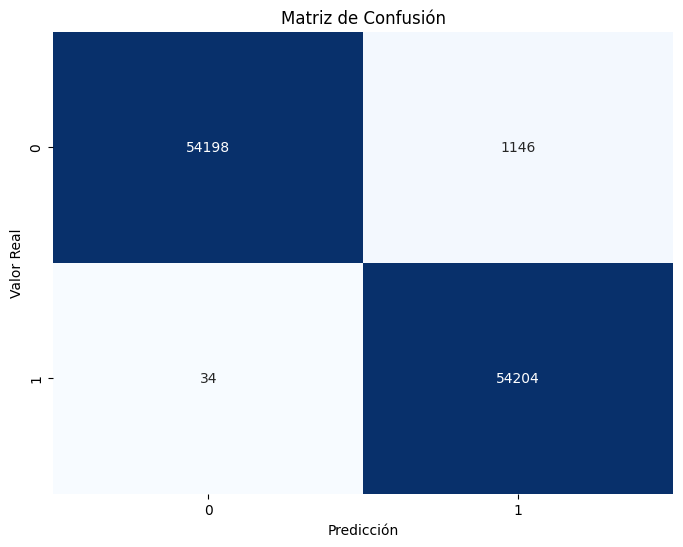

In [16]:
cm = confusion_matrix(y_test, test_predict)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

Matriz de confusión con todos los datos de ggF

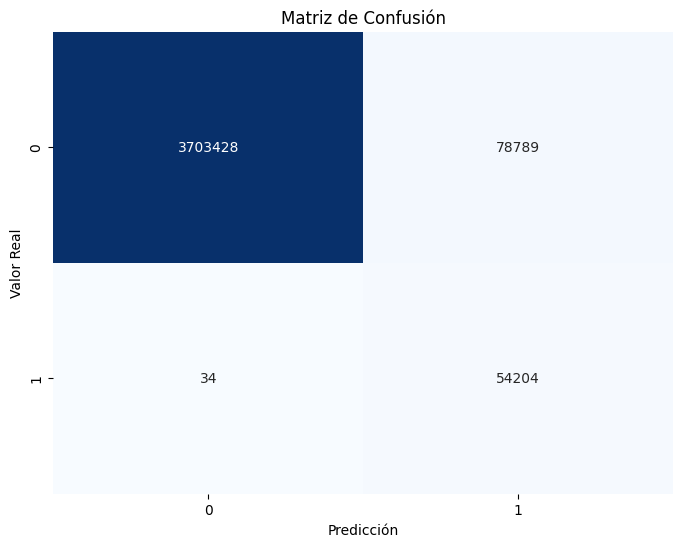

In [17]:
cm2 = confusion_matrix(pd.concat([y_test,y_not_sampled_ggf]), test_predict2)

plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

Clasificación de ggF y VBF

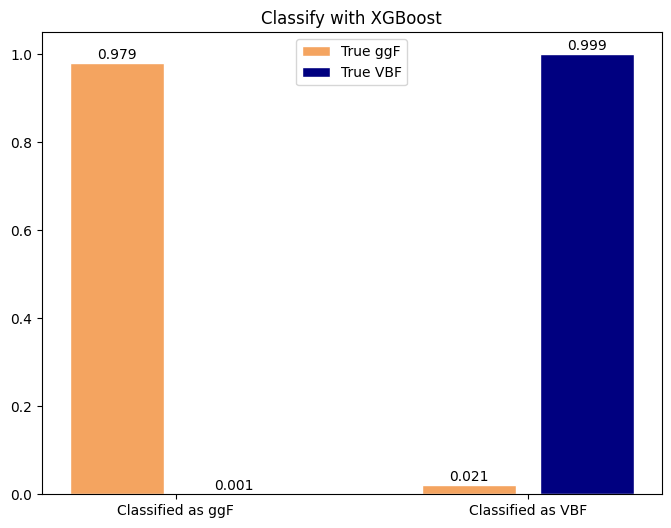

In [18]:
ggf_as_ggf = cm[0,0]
ggf_as_vbf = cm[0,1]
vbf_as_ggf = cm[1,0]
vbf_as_vbf = cm[1,1]
bars1 = np.array([ggf_as_ggf, ggf_as_vbf]) / (ggf_as_ggf+ggf_as_vbf)#+df_not_used[df_not_used['tipo'] == 'ggf'].shape[0])
bars2 = np.array([vbf_as_ggf, vbf_as_vbf]) / (vbf_as_ggf+vbf_as_vbf)#+df_not_used[df_not_used['tipo'] == 'vbf'].shape[0])
pos1 = [0,3]
pos2 = [1,4]
plt.figure(figsize=(8, 6))
plt.bar(pos1, bars1, width=.8, color='sandybrown', edgecolor='white', label='True ggF')
plt.bar(pos2, bars2, width=.8, color="navy", edgecolor='white', label='True VBF')
plt.xticks([.5,3.5] ,['Classified as ggF','Classified as VBF'])

for i in range(2):
     plt.text(pos1[i], bars1[i] + 0.01, str(round(bars1[i],3)), ha='center')
     plt.text(pos2[i], bars2[i] + 0.01, str(round(bars2[i],3)), ha='center')
plt.title("Classify with XGBoost")
plt.legend(loc='upper center')

Clasiciación de ggF y VBF usando todos los datos de ggF

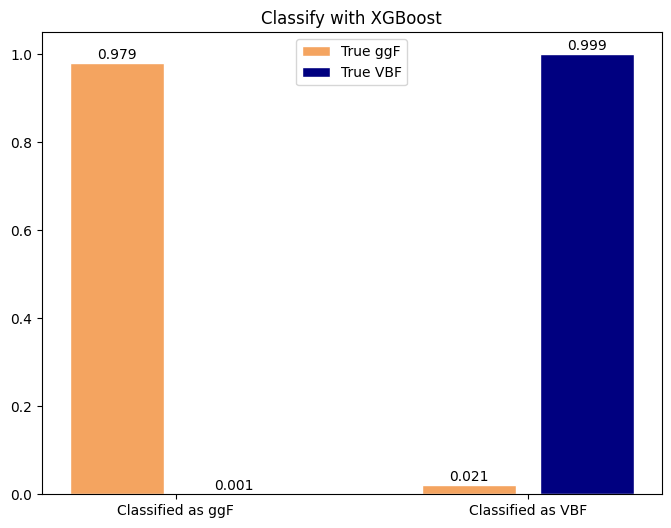

In [19]:
ggf_as_ggf = cm2[0,0]
ggf_as_vbf = cm2[0,1]
vbf_as_ggf = cm2[1,0]
vbf_as_vbf = cm2[1,1]
bars1 = np.array([ggf_as_ggf, ggf_as_vbf]) / (ggf_as_ggf+ggf_as_vbf)#+df_not_used[df_not_used['tipo'] == 'ggf'].shape[0])
bars2 = np.array([vbf_as_ggf, vbf_as_vbf]) / (vbf_as_ggf+vbf_as_vbf)#+df_not_used[df_not_used['tipo'] == 'vbf'].shape[0])
pos1 = [0,3]
pos2 = [1,4]
plt.figure(figsize=(8, 6))
plt.bar(pos1, bars1, width=.8, color='sandybrown', edgecolor='white', label='True ggF')
plt.bar(pos2, bars2, width=.8, color="navy", edgecolor='white', label='True VBF')
plt.xticks([.5,3.5] ,['Classified as ggF','Classified as VBF'])

for i in range(2):
     plt.text(pos1[i], bars1[i] + 0.01, str(round(bars1[i],3)), ha='center')
     plt.text(pos2[i], bars2[i] + 0.01, str(round(bars2[i],3)), ha='center')
plt.title("Classify with XGBoost")
plt.legend(loc='upper center')

In [20]:
print(classification_report(y_test, test_predict))
print(classification_report(pd.concat([y_test,y_not_sampled_ggf]), test_predict2))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     55344
           1       0.98      1.00      0.99     54238

    accuracy                           0.99    109582
   macro avg       0.99      0.99      0.99    109582
weighted avg       0.99      0.99      0.99    109582

              precision    recall  f1-score   support

           0       1.00      0.98      0.99   3782217
           1       0.41      1.00      0.58     54238

    accuracy                           0.98   3836455
   macro avg       0.70      0.99      0.78   3836455
weighted avg       0.99      0.98      0.98   3836455



### Klomogorov-Smirnov Test

### Matriz de correlación

Text(0.5, 1.0, 'Matriz de correlación, variables de entrenamiento')

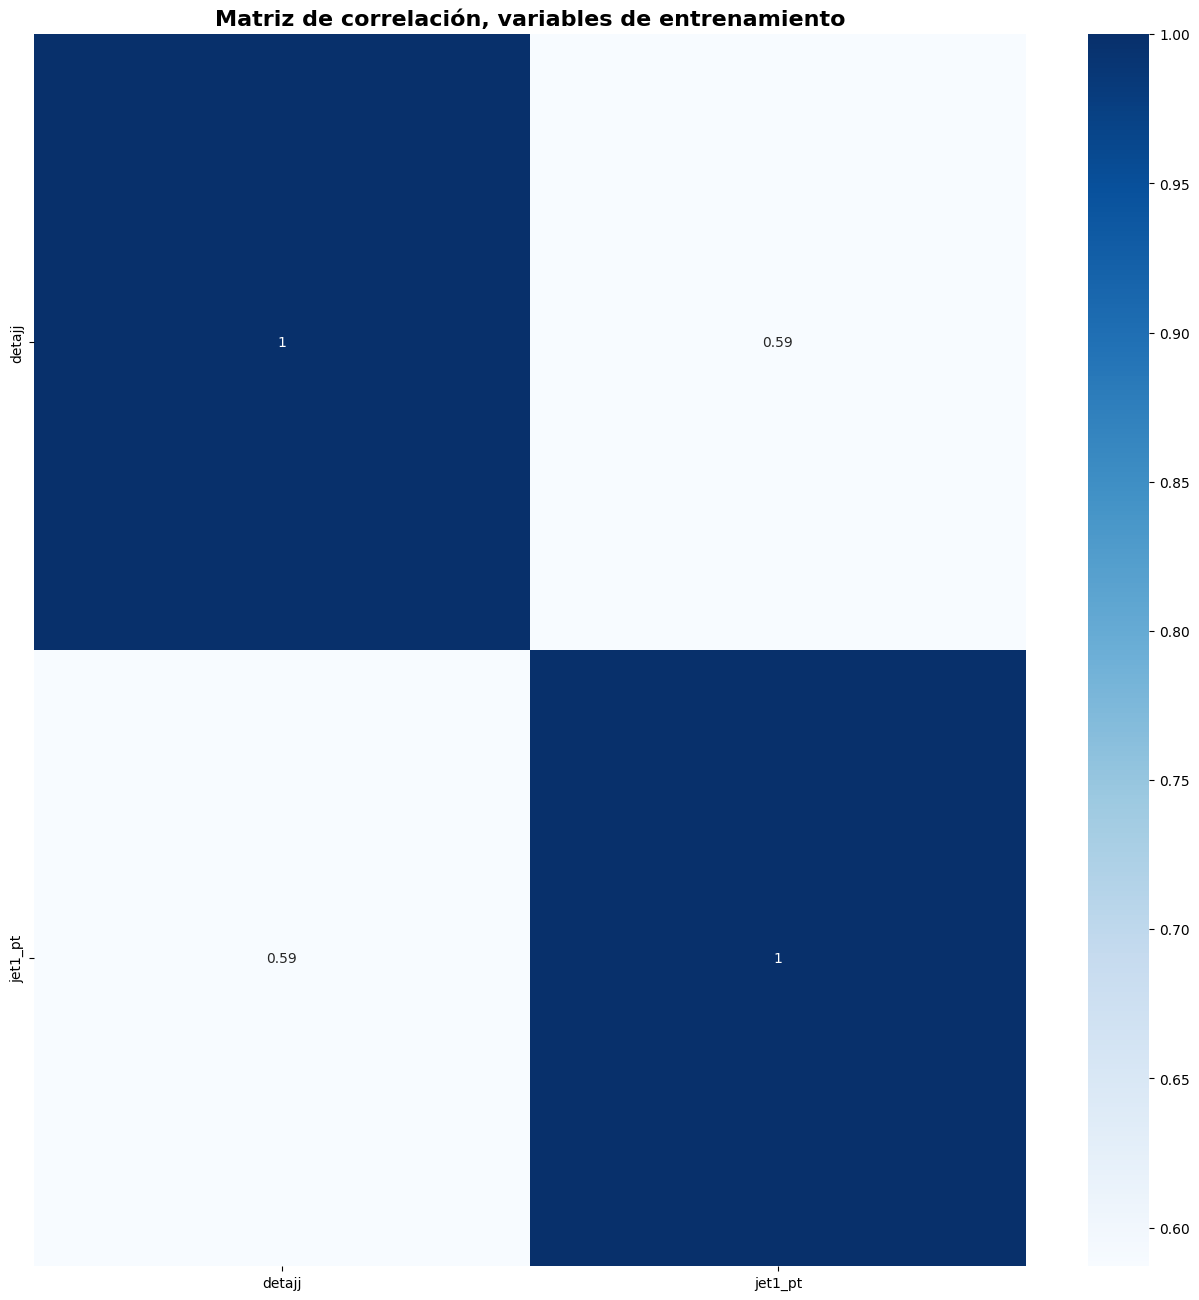

In [21]:
fig, ax = plt.subplots(figsize=(16, 16))

sns.heatmap(X_train.corr().abs().map(lambda x: round(x,5)), cmap='Blues', annot=True)
plt.title("Matriz de correlación, variables de entrenamiento", fontsize=16, fontdict={"weight": "bold"})

### Importancia de cada atributo de la matriz de atributos en el modelo

Importancia de características:
detajj: 0.8988468647003174
jet1_pt: 0.10115309059619904


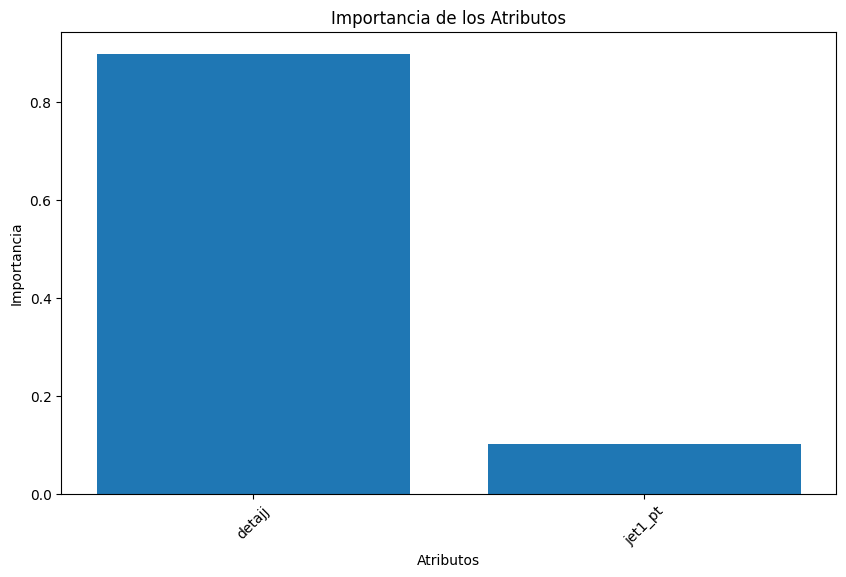

In [22]:
# Obtén la importancia de las características
feature_importance = model.feature_importances_

# Ordena las características por importancia descendente
sorted_idx = feature_importance.argsort()[::-1]

# Imprime las importancias de las características
print("Importancia de características:")
for i in sorted_idx:
    print(f"{X_train.columns[i]}: {feature_importance[i]}")

# Crea el scree plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance[sorted_idx], align="center")
plt.xticks(range(len(feature_importance)), X_train.columns[sorted_idx], rotation=45)
plt.xlabel("Atributos")
plt.ylabel("Importancia")
plt.title("Importancia de los Atributos")
plt.show()


In [23]:
# import factor_analyzer as fact

# fact.calculate_bartlett_sphericity(X_train)
# fact.calculate_kmo(X_train)
# # Generamos una nueva instancia en el objeto factorize e implementamos el análisis
# factorize = fact.FactorAnalyzer(n_factors=10, rotation= None)
# factorize.fit(X_train)
# # extraemos los eigenvalues
# factor_screeplot = factorize.get_eigenvalues()[0]
# # graficamos los eigenvalues contra la cantidad de dimensiones estimables
# plt.plot(range(len(factor_screeplot)), factor_screeplot, 'o-', color='tomato')
# plt.xlabel('Número de Factor')
# plt.ylabel('Valores Propios')
# # visualizamos el criterio de corte
# plt.axhline(1)
# plt.title("Scree plot")

In [24]:

# # Realizar la validación cruzada
# dtrain = xgb.DMatrix(X_train, label=y_train)
# cv_results = xgb.cv(
#     params,
#     dtrain,
#     num_boost_round=1000,
#     nfold=5,
#     early_stopping_rounds=10,
#     verbose_eval=True,
# )

# # Graficar los resultados de la validación cruzada
# # plt.figure(figsize=(10, 6))
# # plt.plot(cv_results['train-rmse-mean'], label='Training RMSE')
# # plt.plot(cv_results['test-rmse-mean'], label='Validation RMSE')
# # plt.xlabel('Número de rondas de refuerzo')
# # plt.ylabel('RMSE')
# # plt.title('Cross Validation Plot')
# plt.legend()
# plt.show()

In [25]:
# plt.plot(cv_results["test-auc-mean"], label="test")
# plt.plot(cv_results["train-auc-mean"], label="train")
# plt.legend()
# plt.ylabel("AUC")
# plt.xlabel("Ronda")
# plt.title("AUC")
# plt.show()

#### Curva ROC

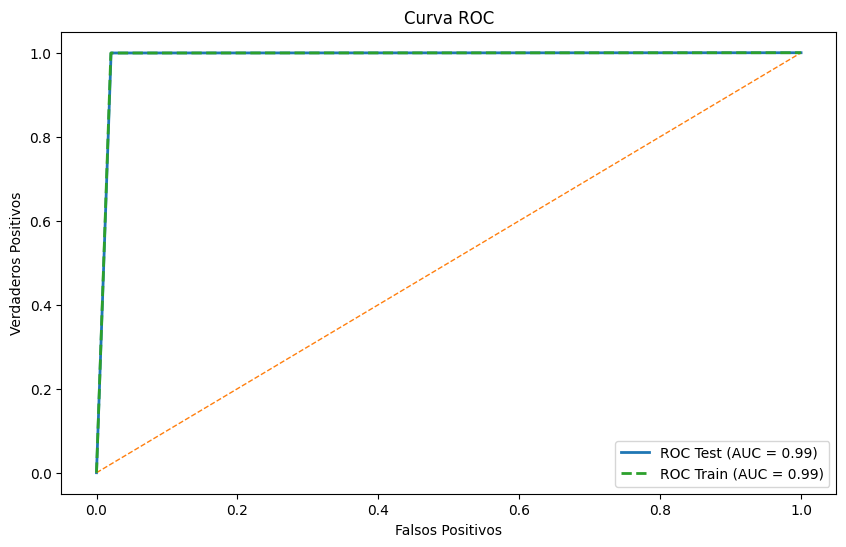

In [26]:
from sklearn.metrics import roc_curve, auc
# reestimamos los valores predichos de nuestro modelo para obtener la probabilidad entre 0 y 1.
# generamos los objetos de roc_cruve
false_positive, true_positive, threshold = roc_curve(y_test, test_predict)
false_positive2, true_positive2, threshold2 = roc_curve(y_train, train_predict)
roc_auc = auc(false_positive, true_positive)
roc_auc2 = auc(false_positive2, true_positive2)

plt.figure(figsize=(10, 6))

# Plot ROC curve
plt.title('Curva ROC')
plt.plot(false_positive, true_positive, lw=2,  label='ROC Test (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], ls="--", lw=1)
plt.plot(false_positive2, true_positive2, lw=2, ls= "--",label='ROC Train (AUC = {:.2f})'.format(roc_auc2))


#plt.plot([0, 0], [1, 0] , c='limegreen', lw=3), plt.plot([1, 1] , c='limegreen', lw=3)
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos')
plt.legend()
plt.show()

#### Métricas de Cross Validation

#### Learning curve

In [27]:

model2 = xgb.XGBClassifier(**params)

train_sizes, train_scores, test_scores = learning_curve(model2, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.001, 1.0, 10), fit_params={'eval_set': eval_set})

[0]	validation_0-logloss:0.61306	validation_0-auc:0.97877
[1]	validation_0-logloss:0.54885	validation_0-auc:0.98042
[2]	validation_0-logloss:0.49589	validation_0-auc:0.98042
[3]	validation_0-logloss:0.45196	validation_0-auc:0.98109
[4]	validation_0-logloss:0.41470	validation_0-auc:0.98109
[5]	validation_0-logloss:0.38230	validation_0-auc:0.99413
[6]	validation_0-logloss:0.35491	validation_0-auc:0.99409
[7]	validation_0-logloss:0.33270	validation_0-auc:0.99418
[8]	validation_0-logloss:0.31201	validation_0-auc:0.99413
[9]	validation_0-logloss:0.29402	validation_0-auc:0.99409
[0]	validation_0-logloss:0.52676	validation_0-auc:0.99076
[1]	validation_0-logloss:0.41375	validation_0-auc:0.99410
[2]	validation_0-logloss:0.33210	validation_0-auc:0.99509
[3]	validation_0-logloss:0.27088	validation_0-auc:0.99545
[4]	validation_0-logloss:0.22349	validation_0-auc:0.99567
[5]	validation_0-logloss:0.18664	validation_0-auc:0.99596
[6]	validation_0-logloss:0.15735	validation_0-auc:0.99655
[7]	validation

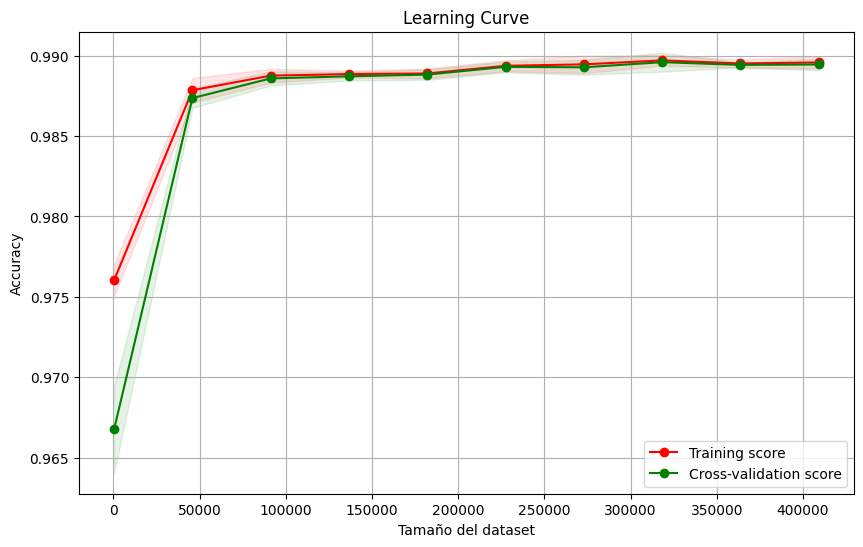

In [29]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)

plt.title("Learning Curve")
plt.xlabel("Tamaño del dataset")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [30]:
# eval_set = [(X_val, y_val)]

# model = xgb.XGBClassifier(**params)
# train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, scoring='neg_log_loss', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42, shuffle=True, verbose=1, fit_params={'eval_set': eval_set})


# train_scores_mean = -np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = -np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)

# plt.figure(figsize=(10, 6))
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
# plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
# plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
# plt.xlabel("Training examples")
# plt.ylabel("Negative Log Loss")
# plt.legend(loc="best")
# plt.show()


In [31]:
model2 = xgb.XGBClassifier(**params)

[0]	validation_0-logloss:0.52357	validation_0-auc:0.99246
[1]	validation_0-logloss:0.40901	validation_0-auc:0.99379
[2]	validation_0-logloss:0.32659	validation_0-auc:0.99467
[3]	validation_0-logloss:0.26453	validation_0-auc:0.99581
[4]	validation_0-logloss:0.21730	validation_0-auc:0.99640
[5]	validation_0-logloss:0.17990	validation_0-auc:0.99683
[6]	validation_0-logloss:0.15087	validation_0-auc:0.99704
[7]	validation_0-logloss:0.12789	validation_0-auc:0.99724
[8]	validation_0-logloss:0.10938	validation_0-auc:0.99752
[9]	validation_0-logloss:0.09467	validation_0-auc:0.99759
[0]	validation_0-logloss:0.52331	validation_0-auc:0.99277
[1]	validation_0-logloss:0.40889	validation_0-auc:0.99362
[2]	validation_0-logloss:0.32697	validation_0-auc:0.99542
[3]	validation_0-logloss:0.26576	validation_0-auc:0.99585
[4]	validation_0-logloss:0.21819	validation_0-auc:0.99653
[5]	validation_0-logloss:0.18174	validation_0-auc:0.99664
[6]	validation_0-logloss:0.15155	validation_0-auc:0.99734
[7]	validation

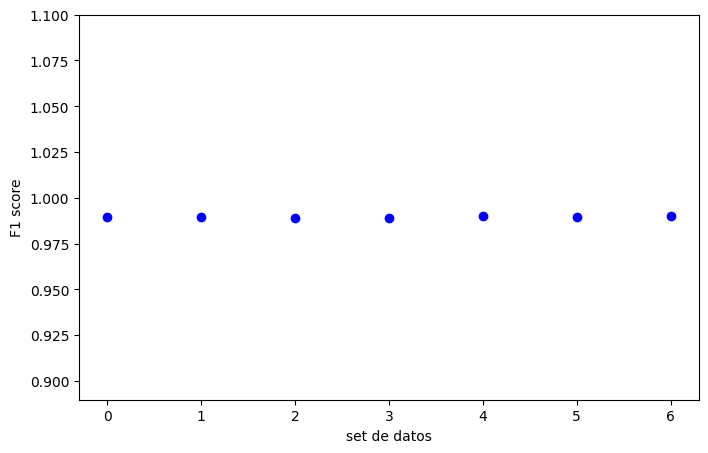

In [32]:
eval_set = [(X_val, y_val)]
cv_scores = cross_val_score(model2, X_train, y_train, cv=7, scoring='f1', fit_params={'eval_set': eval_set})


plt.figure(figsize=[8, 5])

plt.scatter(range(0,7),cv_scores, color = "blue")
plt.xlabel("set de datos")
plt.ylabel("F1 score")
plt.ylim([cv_scores[0]-.1, 1.1])


plt.show()


[0]	validation_0-logloss:0.52357	validation_0-auc:0.99246
[1]	validation_0-logloss:0.40901	validation_0-auc:0.99379
[2]	validation_0-logloss:0.32659	validation_0-auc:0.99467
[3]	validation_0-logloss:0.26453	validation_0-auc:0.99581
[4]	validation_0-logloss:0.21730	validation_0-auc:0.99640
[5]	validation_0-logloss:0.17990	validation_0-auc:0.99683
[6]	validation_0-logloss:0.15087	validation_0-auc:0.99704
[7]	validation_0-logloss:0.12789	validation_0-auc:0.99724
[8]	validation_0-logloss:0.10938	validation_0-auc:0.99752
[9]	validation_0-logloss:0.09467	validation_0-auc:0.99759
[0]	validation_0-logloss:0.52331	validation_0-auc:0.99277
[1]	validation_0-logloss:0.40889	validation_0-auc:0.99362
[2]	validation_0-logloss:0.32697	validation_0-auc:0.99542
[3]	validation_0-logloss:0.26576	validation_0-auc:0.99585
[4]	validation_0-logloss:0.21819	validation_0-auc:0.99653
[5]	validation_0-logloss:0.18174	validation_0-auc:0.99664
[6]	validation_0-logloss:0.15155	validation_0-auc:0.99734
[7]	validation

(0.8897337622339334, 1.1)

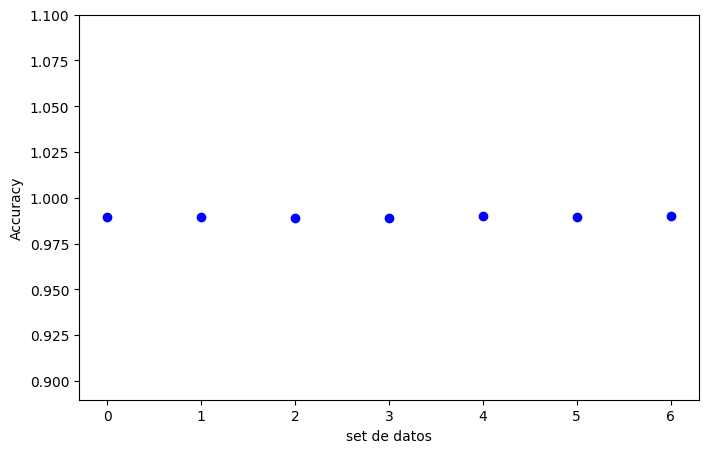

In [33]:
eval_set = [(X_val, y_val)]
cv_scores = cross_val_score(model2, X_train, y_train, cv=7, scoring='accuracy', fit_params={'eval_set': eval_set})

plt.figure(figsize=[8, 5])

plt.scatter(range(0,7),cv_scores, color = "blue")
plt.xlabel("set de datos")
plt.ylabel("Accuracy")
plt.ylim([cv_scores[0]-.1, 1.1])



[0]	validation_0-logloss:0.52357	validation_0-auc:0.99246
[1]	validation_0-logloss:0.40901	validation_0-auc:0.99379
[2]	validation_0-logloss:0.32659	validation_0-auc:0.99467
[3]	validation_0-logloss:0.26453	validation_0-auc:0.99581
[4]	validation_0-logloss:0.21730	validation_0-auc:0.99640
[5]	validation_0-logloss:0.17990	validation_0-auc:0.99683
[6]	validation_0-logloss:0.15087	validation_0-auc:0.99704
[7]	validation_0-logloss:0.12789	validation_0-auc:0.99724
[8]	validation_0-logloss:0.10938	validation_0-auc:0.99752
[9]	validation_0-logloss:0.09467	validation_0-auc:0.99759
[0]	validation_0-logloss:0.52331	validation_0-auc:0.99277
[1]	validation_0-logloss:0.40889	validation_0-auc:0.99362
[2]	validation_0-logloss:0.32697	validation_0-auc:0.99542
[3]	validation_0-logloss:0.26576	validation_0-auc:0.99585
[4]	validation_0-logloss:0.21819	validation_0-auc:0.99653
[5]	validation_0-logloss:0.18174	validation_0-auc:0.99664
[6]	validation_0-logloss:0.15155	validation_0-auc:0.99734
[7]	validation

(0.8974205148676164, 1.1)

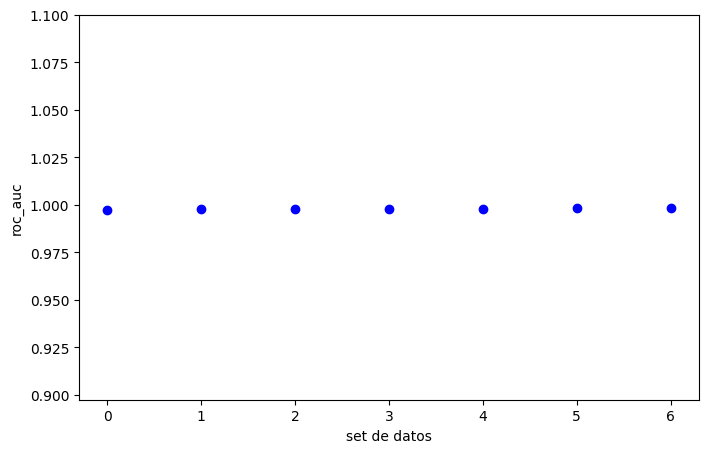

In [34]:
eval_set = [(X_val, y_val)]
cv_scores = cross_val_score(model2, X_train, y_train, cv=7, scoring='roc_auc', fit_params={'eval_set': eval_set})

plt.figure(figsize=[8, 5])

plt.scatter(range(0,7),cv_scores, color = "blue")
plt.xlabel("set de datos")
plt.ylabel("roc_auc")
plt.ylim([cv_scores[0]-.1, 1.1])



Distribución de probabilidad y Kolmogorov-Smirnov Test

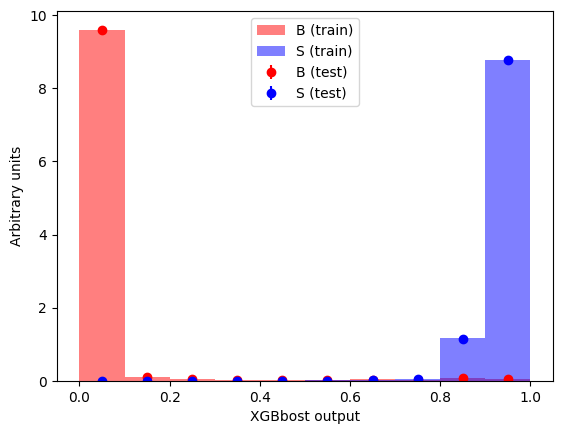

In [36]:
 # Overtraining Check
# A popular way in HEP to check overtraining is to output training and testing distributions (but there are others) and see the difference between them.

def compare_train_test(clf, X_train, y_train, X_test, y_test):
    decisions = [] 
    for X, y in ((X_train, y_train), (X_test, y_test)):
        probas = clf.predict_proba(X)[:, 1]  # Obtener la probabilidad de la clase 1
        d1 = probas[y < 0.5].ravel()  # background
        d2 = probas[y > 0.5].ravel()  # signal
        decisions += [d1, d2]
    
    
    highest_decision = max(np.max(d) for d in decisions) # get maximum score
    bin_edges = [] # list to hold bin edges
    bin_edge = -0.1 # start counter for bin_edges
    while bin_edge < highest_decision: # up to highest score
        bin_edge += 0.1 # increment
        bin_edges.append(bin_edge)
    
    plt.hist(decisions[0], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='red', label='B (train)', # Background (train)
            alpha=0.5 ) # half transparency
    plt.hist(decisions[1], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='blue', label='S (train)', # Signal (train)
            alpha=0.5 ) # half transparency

    hist_background, bin_edges = np.histogram(decisions[2], # background test
                                              bins=bin_edges, # number of bins in function definition
                                              density=True ) # area under the histogram will sum to 1
    
    scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
    err_background = np.sqrt(hist_background * scale) / scale # error on test background

    width = 0.1 # histogram bin width
    center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres
    
    plt.errorbar(x=center, y=hist_background, yerr=err_background, fmt='o', # circles
                 c='red', label='B (test)' ) # Background (test)
    
    hist_signal, bin_edges = np.histogram(decisions[3], # siganl test
                                          bins=bin_edges, # number of bins in function definition
                                          density=True ) # area under the histogram will sum to 1
    scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
    err_signal = np.sqrt(hist_signal * scale) / scale # error on test background
    
    plt.errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='o', # circles
                 c='blue', label='S (test)' ) # Signal (test)

    # calculate de kolmogorov-smirnov test
    #ks = stats.ks_2samp(decisions[2], decisions[3]) # test statistic and p-value
    #plt.title("KS test: %.3f, p-value %.3f"%(ks[0], ks[1])) # add title

    plt.xlabel("XGBbost output") # write x-axis label
    plt.ylabel("Arbitrary units") # write y-axis label
    plt.legend(loc='upper center') # add legend
    
compare_train_test(model, X_train, y_train, X_test, y_test) # call compare_train_test

In [37]:
from scipy import stats

# Probabilidades de la clase positiva (usualmente señal)
probas_train_signal = model.predict_proba(X_train)[:, 1][y_train > 0.5].ravel()
probas_test_signal = model.predict_proba(X_test)[:, 1][y_test > 0.5].ravel()

# Prueba KS para la señal
ks_signal = stats.ks_2samp(probas_train_signal, probas_test_signal)
print("KS test Signal: %.3f, p-value %.3f" % (ks_signal.statistic, ks_signal.pvalue))

# Probabilidades de la clase negativa (usualmente fondo)
probas_train_background = model.predict_proba(X_train)[:, 1][y_train < 0.5].ravel()
probas_test_background = model.predict_proba(X_test)[:, 1][y_test < 0.5].ravel()

# Prueba KS para el fondo
ks_background = stats.ks_2samp(probas_train_background, probas_test_background)
print("KS test Background: %.3f, p-value %.3f" % (ks_background.statistic, ks_background.pvalue))


KS test Signal: 0.002, p-value 0.982
KS test Background: 0.001, p-value 1.000


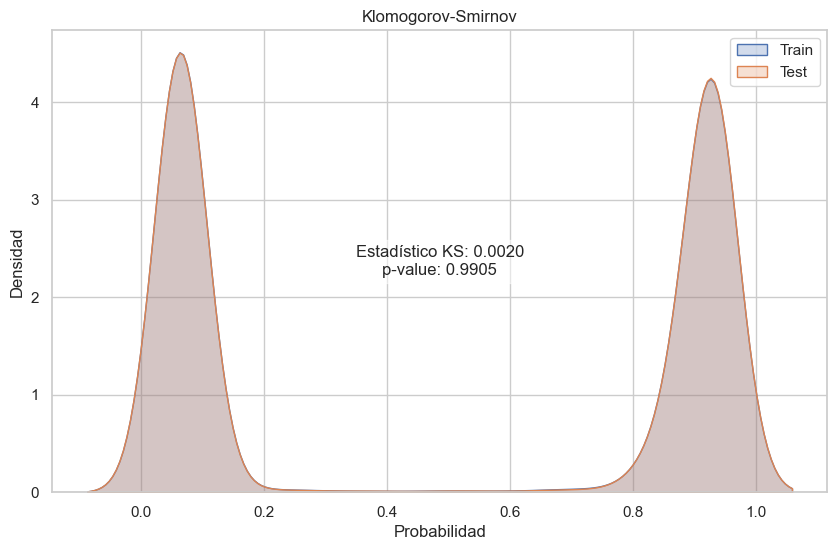

In [38]:
probs_train = model.predict_proba(X_train.sample(n=100000, random_state = 1228))[:, 1] 
probs_test = model.predict_proba(X_test.sample(n=100000,random_state=1228))[:, 1]    
ks_test, p_value = ks_2samp(probs_train, probs_test)


sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.kdeplot(probs_train, label="Train", shade=True)
sns.kdeplot(probs_test, label="Test", shade=True)

plt.title("Klomogorov-Smirnov")
plt.xlabel("Probabilidad")
plt.ylabel("Densidad")
plt.legend()
plt.text(0.5, 0.5, f"Estadístico KS: {ks_test:.4f}\np-value: {p_value:.4f}", 
         horizontalalignment='center', verticalalignment='center', 
         transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()


In [39]:
trees = model.get_booster().get_dump()
for i, tree_dump in enumerate(trees):
    print(f"Árbol {i + 1}:\n")
    print(tree_dump)
    print("\n" + "=" * 50 + "\n")

Árbol 1:

0:[detajj<0.689234853] yes=1,no=2,missing=2
	1:[jet1_pt<1.45928001] yes=3,no=4,missing=4
		3:[jet1_pt<1.1236062] yes=7,no=8,missing=8
			7:leaf=-0.39940536
			8:leaf=-0.217031106
		4:[detajj<0.686376154] yes=9,no=10,missing=10
			9:leaf=-0.367233902
			10:leaf=0.302718371
	2:[jet1_pt<-0.488444954] yes=5,no=6,missing=6
		5:[detajj<0.694565117] yes=11,no=12,missing=12
			11:leaf=-0.382626206
			12:leaf=0.302773893
		6:[detajj<0.690695882] yes=13,no=14,missing=14
			13:leaf=0.25943628
			14:leaf=0.389385164



Árbol 2:

0:[detajj<0.689112484] yes=1,no=2,missing=2
	1:[jet1_pt<1.65775323] yes=3,no=4,missing=4
		3:[jet1_pt<1.22014177] yes=7,no=8,missing=8
			7:leaf=-0.333557129
			8:leaf=-0.168871984
		4:[detajj<0.686376154] yes=9,no=10,missing=10
			9:leaf=-0.303672761
			10:leaf=0.255680263
	2:[jet1_pt<-0.444055378] yes=5,no=6,missing=6
		5:[detajj<0.694196403] yes=11,no=12,missing=12
			11:leaf=-0.334753454
			12:leaf=0.262130886
		6:[detajj<0.690217495] yes=13,no=14,missing=14
